In [1]:
import os
import numpy as np

frames = os.listdir('framesResult')

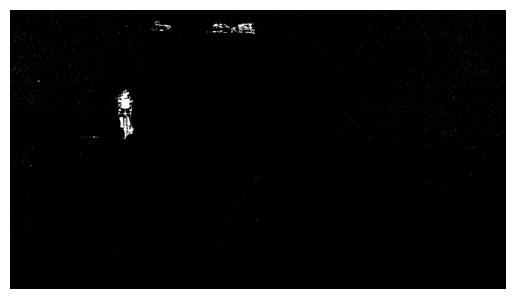

In [2]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

image = cv2.imread('framesResult/' + frames[100], cv2.IMREAD_COLOR)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

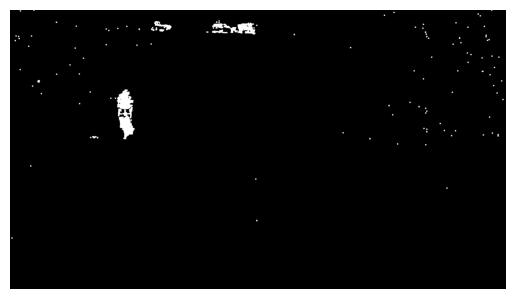

In [23]:
morphed = cv2.morphologyEx(image, cv2.MORPH_ERODE, (1000, 500))
morphed = cv2.morphologyEx(morphed, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
plt.imshow(morphed, cmap='gray')
plt.axis('off')
plt.show()

8


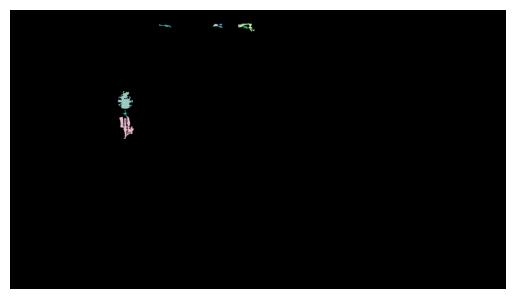

In [18]:
if len(image.shape) > 2:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

output_image = np.zeros_like(image)

min_area_threshold = 100

contador = 0

for i in range(1, num_labels):  # Exclude background label which is 0
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= min_area_threshold:
        contador += 1
        mask = labels == i
        color = np.random.randint(0, 255, size=3)  # Generate a random color
        output_image[mask] = color

print(contador)

plt.imshow(output_image)
plt.axis('off')
plt.show()

In [24]:
import xml.etree.ElementTree as ET

label_file = 'ai_challenge_s03_c010-full_annotation.xml'
tree = ET.parse(label_file)
root = tree.getroot()

frame_dict = {}

for track in root.findall(".//track[@label='car']"):

In [40]:
tree = ET.parse(label_file)
root = tree.getroot()

bbox_info = {}

for box in root.findall('./track/box'):
    frame = int(box.attrib['frame'])
    xtl = float(box.attrib['xtl'])
    ytl = float(box.attrib['ytl'])
    xbr = float(box.attrib['xbr'])
    ybr = float(box.attrib['ybr'])
    
    bbox_info.setdefault(frame, []).append({
        'xtl': xtl,
        'ytl': ytl,
        'xbr': xbr,
        'ybr': ybr,
    })

In [41]:
bbox_info

{86: [{'xtl': 536.35, 'ytl': 41.15, 'xbr': 591.37, 'ybr': 81.14},
  {'xtl': 558.36, 'ytl': 94.45, 'xbr': 663.49, 'ybr': 169.31},
  {'xtl': 573.7, 'ytl': 72.89, 'xbr': 661.41, 'ybr': 145.05},
  {'xtl': 913.24, 'ytl': 93.02, 'xbr': 972.14, 'ybr': 144.57},
  {'xtl': 894.24, 'ytl': 95.32, 'xbr': 944.92, 'ybr': 144.0},
  {'xtl': 878.4, 'ytl': 107.28, 'xbr': 927.5, 'ybr': 145.72},
  {'xtl': 424.74, 'ytl': 279.34, 'xbr': 486.46, 'ybr': 463.06},
  {'xtl': 1176.01, 'ytl': 82.17, 'xbr': 1253.12, 'ybr': 174.08},
  {'xtl': 1285.84, 'ytl': 363.23, 'xbr': 1516.36, 'ybr': 546.91},
  {'xtl': 931.96, 'ytl': 78.33, 'xbr': 1013.32, 'ybr': 146.01}],
 87: [{'xtl': 554.18, 'ytl': 40.93, 'xbr': 609.19, 'ybr': 80.93},
  {'xtl': 558.36, 'ytl': 94.45, 'xbr': 663.49, 'ybr': 169.31},
  {'xtl': 573.7, 'ytl': 72.89, 'xbr': 661.41, 'ybr': 145.05},
  {'xtl': 913.24, 'ytl': 93.02, 'xbr': 972.14, 'ybr': 144.57},
  {'xtl': 894.24, 'ytl': 95.32, 'xbr': 944.92, 'ybr': 144.0},
  {'xtl': 878.4, 'ytl': 107.28, 'xbr': 927.5, 